In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.stats as stats
import geopandas as gpd
from shapely import wkt
import colorcet as cc
from matplotlib.colors import ListedColormap
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import colorcet as cc
import os

In [13]:
# Define base paths
data_dir = "../../data/loaded"
Images_dir = "../../images/EDA_1"
landcover_file_path = os.path.join(data_dir, "landcover.csv")

In [14]:
landcover_df = pd.read_csv(landcover_file_path)

## General inspection

In [15]:
landcover_df.head()

ID  GRIDCODE       AREA_M2       LCCCode  \
0   4       210  6.228187e+06  7001 // 8001   
1   2       210  6.242408e+06  7001 // 8001   
2   1       210  1.482995e+06  7001 // 8001   
3   8        50  4.590841e+08  21497-121340   
4  13       210  6.371533e+06  7001 // 8001   

                                            geometry  
0  POLYGON ((6.415277779717008 37.086959465484505...  
1  POLYGON ((7.180840924329724 37.079166666715295...  
2  POLYGON ((7.371374609418377 37.0819444444929, ...  
3  POLYGON ((6.123611113048653 36.68472222226833,...  
4  POLYGON ((6.261814820345212 37.02361111115902,...

In [16]:
print("shape:", landcover_df.shape)
print("columns:", landcover_df.columns.tolist())
print("missing values:\n", landcover_df.isnull().sum())

shape: (438513, 5)
columns: ['ID', 'GRIDCODE', 'AREA_M2', 'LCCCode', 'geometry']
missing values:
 ID          0
GRIDCODE    0
AREA_M2     0
LCCCode     0
geometry    0
dtype: int64


In [6]:
landcover_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438513 entries, 0 to 438512
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        438513 non-null  int64  
 1   GRIDCODE  438513 non-null  int64  
 2   AREA_M2   438513 non-null  float64
 3   LCCCode   438513 non-null  object 
 4   geometry  438513 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 16.7+ MB


In [7]:
landcover_df.describe()

ID       GRIDCODE       AREA_M2
count  438513.000000  438513.000000  4.385130e+05
mean   173378.294498     156.209934  5.636630e+06
std    117981.553876      65.661496  1.192254e+09
min         1.000000      14.000000  1.002300e+05
25%     57570.000000     150.000000  1.727640e+05
50%    167198.000000     200.000000  3.102027e+05
75%    276826.000000     200.000000  6.763858e+05
max    386454.000000     210.000000  6.720004e+11

In [8]:
# nb unique values per column
for col in landcover_df.columns:
    print(f"{col}: {landcover_df[col].nunique()} unique values")

ID: 386454 unique values
GRIDCODE: 22 unique values
AREA_M2: 250950 unique values
LCCCode: 22 unique values
geometry: 438513 unique values


In [10]:
# check number of unique grid and lcccode combinations
unique_combinations = landcover_df[['GRIDCODE', 'LCCCode']].drop_duplicates()
print("Number of unique grid and lcccode combinations:", unique_combinations.shape[0])

Number of unique grid and lcccode combinations: 22


## Univariate Analysis

In [45]:
# function to plot univariate distributions
# - plots histogram and boxplot for numerical variables (num bins calculated using Sturges' rule)
# - plots bar plot for categorical variables
# - checks summary statistics for numerical variables
# - checks mode for categorical variables
# - checks outliers (number, percentage, low, high) for numerical variables using IQR method
def plot_univariate_distribution(column, type, color):   
    print(f"\n$$$$$$$$$$$$$$$$ Univariate analysis for {column}:$$$$$$$$$$$$$$$$\n")
    if type == "numerical":
        # Plot histogram
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(data=landcover_df, x=column, bins='sturges', color=color)
        plt.title(f"Histogram of {column}")
        plt.subplot(1, 2, 2)
        sns.boxplot(data=landcover_df, x=column, color=color)
        plt.title(f"Boxplot of {column}")
        plt.savefig(os.path.join(Images_dir, f"landcover_hist_boxplot_{column}.png"), bbox_inches='tight')
        plt.show()
        # Print summary statistics
        print(f"Summary statistics for {column}:")
        print(landcover_df[column].describe())
        # Check for outliers using IQR
        Q1 = landcover_df[column].quantile(0.25)
        Q3 = landcover_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = landcover_df[(landcover_df[column] < lower_bound) | (landcover_df[column] > upper_bound)]
        # Print outlier information
        print(f"Number of outliers in {column}: {outliers.shape[0]}")
        print(f"Percentage of outliers in {column}: {outliers.shape[0] / landcover_df.shape[0] * 100:.2f}%")
        if not outliers.empty:
            print(f"number of Low outliers in {column}:", len(outliers[outliers[column] < lower_bound]))
            print(f"number of High outliers in {column}:", len(outliers[outliers[column] > upper_bound]))
            print()
    else:
            # Plot bar plot sorted by count
            plt.figure(figsize=(12, 4))
            order = landcover_df[column].value_counts().index
            sns.countplot(data=landcover_df, x=column, order=order, palette=color, hue=column, legend=False)
            # vertical x-axis labels for better readability
            plt.xticks(rotation=90)
            plt.title(f"Bar plot of {column}")
            plt.savefig(os.path.join(Images_dir, f"lancover_barplot_{column}.png"), bbox_inches='tight')
            plt.show()
            # Print mode
            print(f"Mode of {column}: {landcover_df[column].mode()[0]}")

In [17]:
numerical_columns = ['AREA_M2']
cat_columns = ['GRIDCODE', 'LCCCode']


$$$$$$$$$$$$$$$$ Univariate analysis for AREA_M2:$$$$$$$$$$$$$$$$



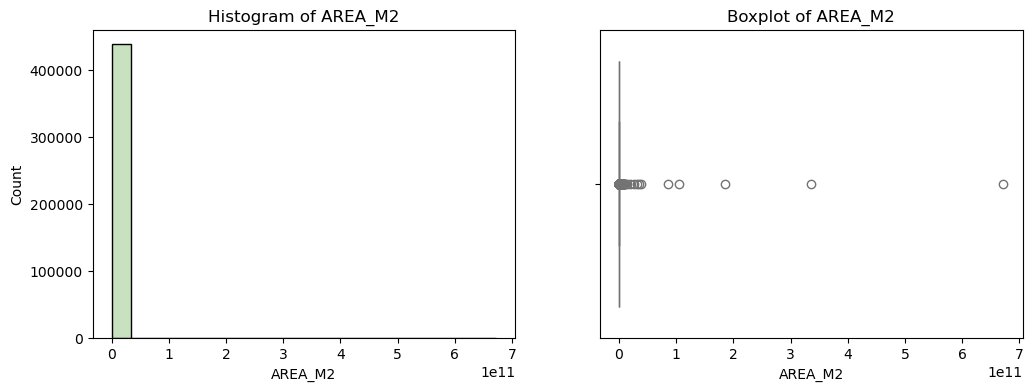

Summary statistics for AREA_M2:
count    4.385130e+05
mean     5.636630e+06
std      1.192254e+09
min      1.002300e+05
25%      1.727640e+05
50%      3.102027e+05
75%      6.763858e+05
max      6.720004e+11
Name: AREA_M2, dtype: float64
Number of outliers in AREA_M2: 53573
Percentage of outliers in AREA_M2: 12.22%
number of Low outliers in AREA_M2: 0
number of High outliers in AREA_M2: 53573


$$$$$$$$$$$$$$$$ Univariate analysis for GRIDCODE:$$$$$$$$$$$$$$$$



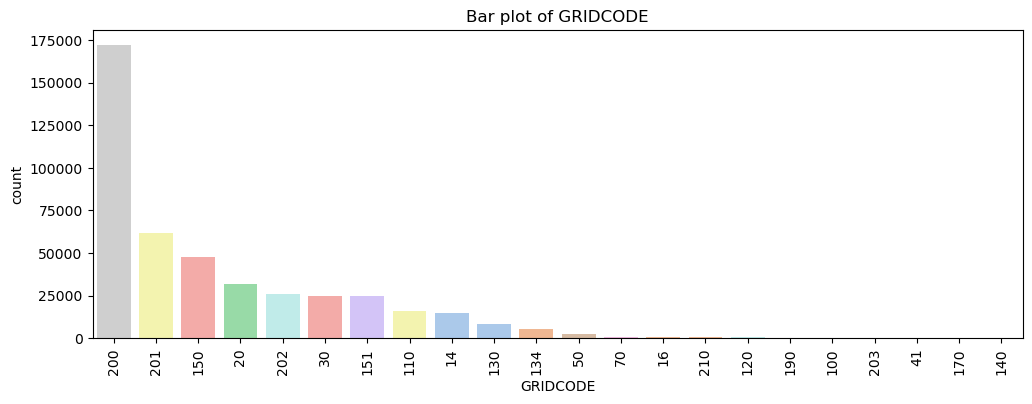

Mode of GRIDCODE: 200

$$$$$$$$$$$$$$$$ Univariate analysis for LCCCode:$$$$$$$$$$$$$$$$



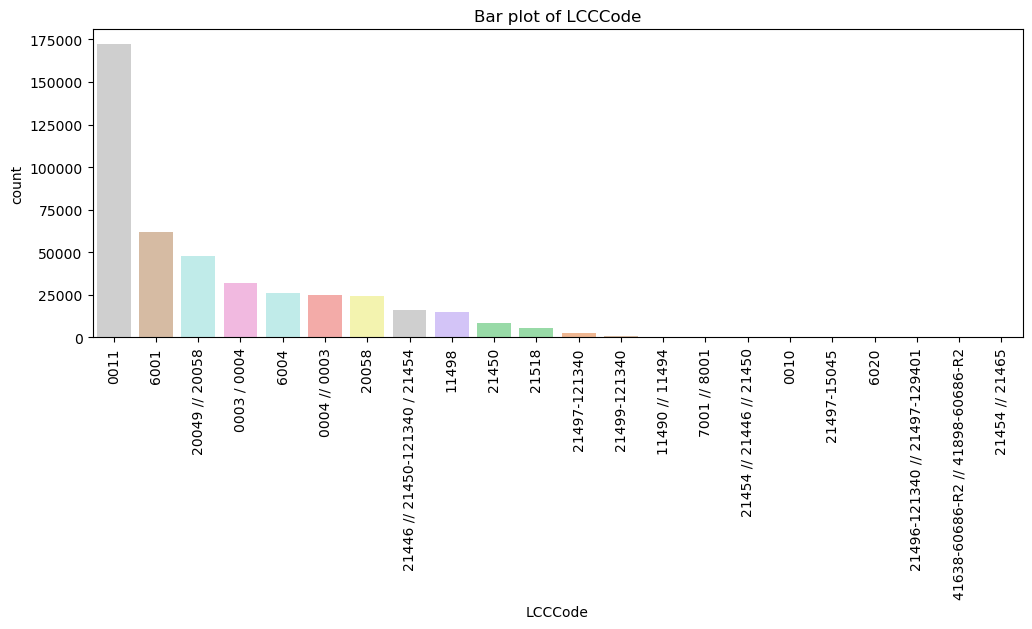

Mode of LCCCode: 0011


In [46]:
for col in numerical_columns:
    plot_univariate_distribution(col, type="numerical", color="#b6d7a8")

for col in cat_columns:
    plot_univariate_distribution(col, type="categorical", color="pastel")

### LCCCode

for LCCCode we have legend file that wa can see with what each code refer to

In [17]:
# get legend file path
legend_file_path = "../../data/globcover_LCCS_legend_africa.xls"
legend_df = pd.read_excel(legend_file_path)

In [18]:
# create merged dataframe to map LCCCode to description then print value counts with descriptions
# print count number on left and description on right with code in the middle
merged_df = landcover_df.merge(legend_df, left_on='LCCCode', right_on='LCCCode', how='left')
lcccode_counts = merged_df['LCCLabel'].value_counts()
print("LCCCode value counts with descriptions:")
for label, count in lcccode_counts.items():
    code = merged_df[merged_df['LCCLabel'] == label]['LCCCode'].values[0]
    print("-"*100)
    print(f"{count}: {code} : {label}")

LCCCode value counts with descriptions:
----------------------------------------------------------------------------------------------------
172221: 0011 : Bare Area(s)
----------------------------------------------------------------------------------------------------
61857: 6001 : Consolidated Material(s)
----------------------------------------------------------------------------------------------------
47560: 20049 // 20058 : Sparse Woody Vegetation
 // Herbaceous Sparse Vegetation
----------------------------------------------------------------------------------------------------
31891: 0003 / 0004 : Cultivated and Managed Terrestrial Area(s)
 / Natural And Semi-Natural Primarily Terrestrial Vegetation
----------------------------------------------------------------------------------------------------
25951: 6004 : Unconsolidated Material(s)
----------------------------------------------------------------------------------------------------
24856: 0004 // 0003 : Natural And Semi-N

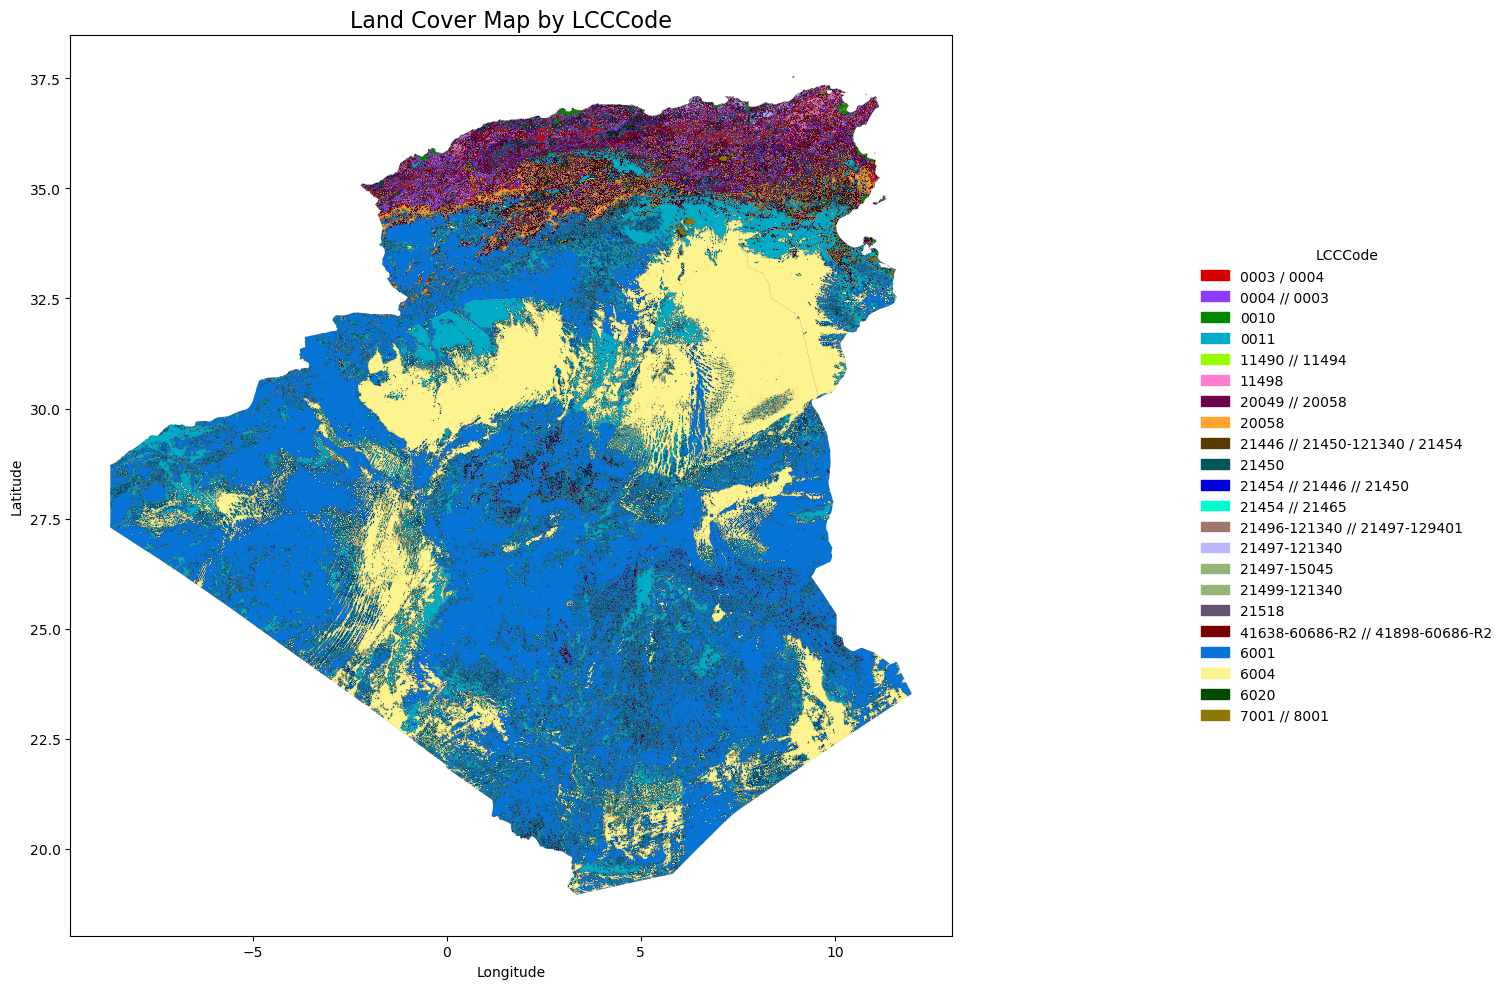

In [20]:
from shapely import wkt

landcover_df['geometry'] = landcover_df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(landcover_df, geometry='geometry', crs="EPSG:4326")


# Create color palette
palette = sns.color_palette(cc.glasbey, n_colors=gdf['LCCCode'].nunique())
cmap = ListedColormap(palette)

# Create two subplots: map (left) + legend (right)
fig, (ax_map, ax_legend) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [4, 0.5]})

# --- Plot the map ---
gdf.plot(
    column='LCCCode',
    cmap=cmap,
    linewidth=0.05,
    edgecolor='black',
    ax=ax_map,
    legend=False
)

ax_map.set_title("Land Cover Map by LCCCode", fontsize=16)
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")

# --- Create a separate legend on the right ---
# Get unique LCC codes
unique_codes = gdf['LCCCode'].unique()
unique_codes.sort()

# Create legend handles
from matplotlib.patches import Patch
handles = [Patch(color=cmap(i / len(unique_codes)), label=str(code)) for i, code in enumerate(unique_codes)]

ax_legend.legend(
    handles=handles,
    title="LCCCode",
    loc="center left",
    frameon=False
)
ax_legend.axis('off')  # remove axes for the legend subplot

# --- Final layout ---
plt.tight_layout()
plt.savefig(os.path.join(Images_dir, "landcover_map_LCCCode_clean.png"), dpi=300, bbox_inches='tight')
plt.show()


) missing from font(s) DejaVu Sans.ykernel_2844\2100708036.py:55: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.ykernel_2844\2100708036.py:56: UserWarning: Glyph 13 (
  plt.savefig(os.path.join(Images_dir, "landcover_map_LCCCode_labelled.png"), dpi=300, bbox_inches='tight')
) missing from font(s) DejaVu Sans.n\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


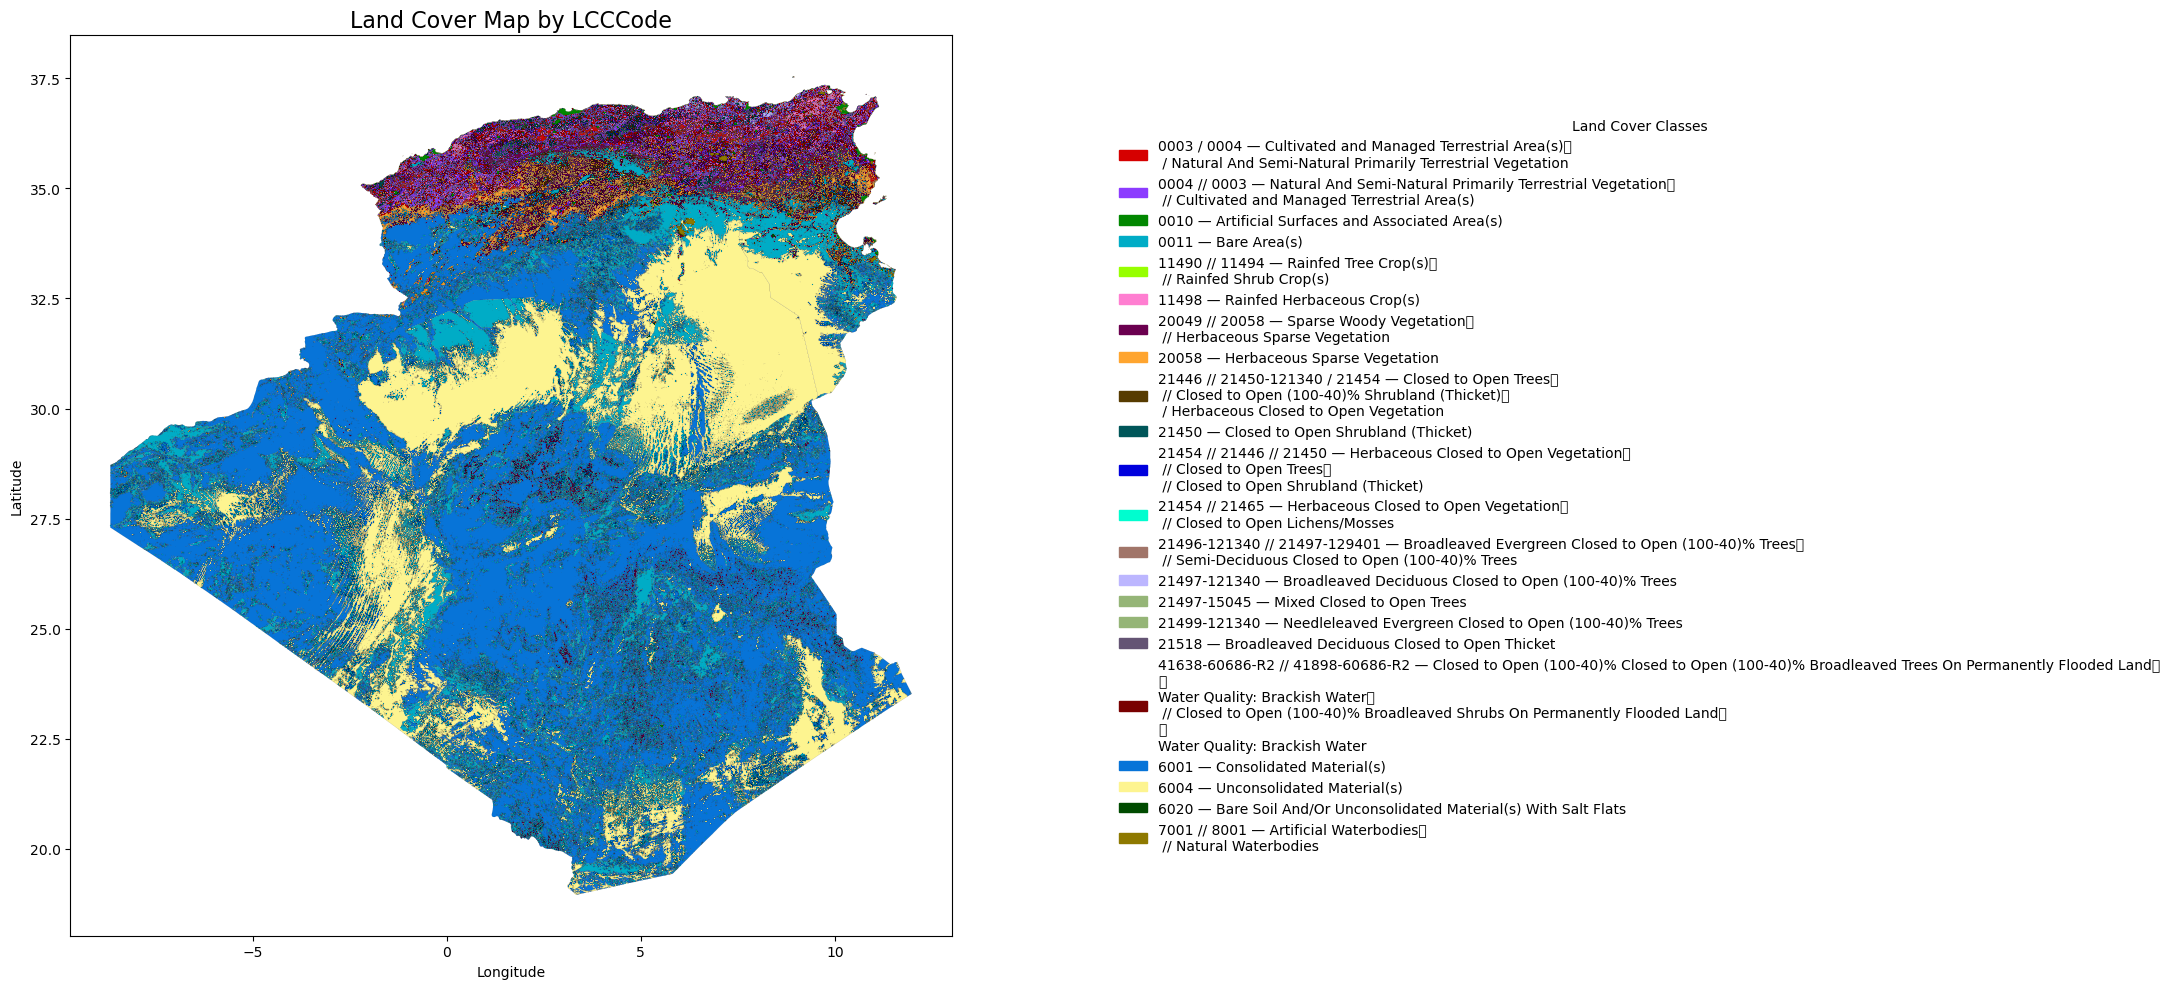

In [ ]:
# Merge with legend to get LCCLabel
merged_gdf = gdf.merge(legend_df[['LCCCode', 'LCCLabel']], on='LCCCode', how='left')

# Create color palette
palette = sns.color_palette(cc.glasbey, n_colors=merged_gdf['LCCCode'].nunique())
cmap = ListedColormap(palette)

# Create two subplots: map (left) + legend (right)
fig, (ax_map, ax_legend) = plt.subplots(
    1, 2, figsize=(28, 10),
    gridspec_kw={'width_ratios': [4, 0.7]}
)

# --- Plot the map ---
merged_gdf.plot(
    column='LCCCode',
    cmap=cmap,
    linewidth=0.05,
    edgecolor='black',
    ax=ax_map,
    legend=False
)

ax_map.set_title("Land Cover Map by LCCCode", fontsize=16)
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")

# --- Create legend using LCCLabel ---
unique_codes = merged_gdf[['LCCCode', 'LCCLabel']].drop_duplicates().sort_values('LCCCode')

# Create color handles with labels
handles = [
    Patch(color=cmap(i / len(unique_codes)), label=f"{row['LCCCode']} — {row['LCCLabel']}")
    for i, (_, row) in enumerate(unique_codes.iterrows())
]

ax_legend.legend(
    handles=handles,
    title="Land Cover Classes",
    loc="center left",
    frameon=False,
    fontsize=10
)
ax_legend.axis('off')

# --- Final layout ---
plt.tight_layout()
plt.savefig(os.path.join(Images_dir, "landcover_map_LCCCode_labelled.png"), dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# add LCCLabel to landcover_df
landcover_df = landcover_df.merge(legend_df[['LCCCode', 'LCCLabel']], on='LCCCode', how='left')

### Gridcode

In [36]:
# Get legend file path and load legend
legend_file_path = "../../data/globcover_legend.xls"
legend_df = pd.read_excel(legend_file_path)

# Merge to attach labels (descriptions) to each GRIDCODE
merged_df = landcover_df.merge(legend_df, left_on='GRIDCODE', right_on='Value', how='left')

# Count each GRIDCODE and get corresponding label
gridcode_counts = merged_df['GRIDCODE'].value_counts()

print("GridCode value counts with descriptions:")
for code, count in gridcode_counts.items():
    label = merged_df.loc[merged_df['GRIDCODE'] == code, 'Label'].iloc[0] if not merged_df.loc[merged_df['GRIDCODE'] == code, 'Label'].empty else "Unknown"
    print(f"{count:<10} | {code:<5} | {label}")


GridCode value counts with descriptions:
172221     | 200   | Bare areas
61857      | 201   | nan
47560      | 150   | Sparse (<15%) vegetation
31891      | 20    | Mosaic cropland (50-70%) / vegetation (grassland/shrubland/forest) (20-50%)
25951      | 202   | nan
24856      | 30    | Mosaic vegetation (grassland/shrubland/forest) (50-70%) / cropland (20-50%) 
24520      | 151   | nan
16002      | 110   | Mosaic forest or shrubland (50-70%) / grassland (20-50%)
14872      | 14    | Rainfed croplands
8248       | 130   | Closed to open (>15%) (broadleaved or needleleaved, evergreen or deciduous) shrubland (<5m)
5432       | 134   | nan
2575       | 50    | Closed (>40%) broadleaved deciduous forest (>5m)
818        | 70    | Closed (>40%) needleleaved evergreen forest (>5m)
550        | 16    | nan
538        | 210   | Water bodies
405        | 120   | Mosaic grassland (50-70%) / forest or shrubland (20-50%) 
145        | 190   | Artificial surfaces and associated areas (Urban areas >5

In [37]:
# Treat all GRIDCODEs with label 'nan' as a single class 0
nan_mask = merged_df['Label'].isna()
merged_df.loc[nan_mask, 'GRIDCODE'] = 0
merged_df.loc[nan_mask, 'Label'] = 'nan'

# Count each GRIDCODE and get corresponding label
gridcode_counts = merged_df['GRIDCODE'].value_counts()

print("GridCode value counts with descriptions:")
for code, count in gridcode_counts.items():
    label = merged_df.loc[merged_df['GRIDCODE'] == code, 'Label'].iloc[0]
    print(f"{count:<10} | {code:<5} | {label}")


GridCode value counts with descriptions:
172221     | 200   | Bare areas
118326     | 0     | nan
47560      | 150   | Sparse (<15%) vegetation
31891      | 20    | Mosaic cropland (50-70%) / vegetation (grassland/shrubland/forest) (20-50%)
24856      | 30    | Mosaic vegetation (grassland/shrubland/forest) (50-70%) / cropland (20-50%) 
16002      | 110   | Mosaic forest or shrubland (50-70%) / grassland (20-50%)
14872      | 14    | Rainfed croplands
8248       | 130   | Closed to open (>15%) (broadleaved or needleleaved, evergreen or deciduous) shrubland (<5m)
2575       | 50    | Closed (>40%) broadleaved deciduous forest (>5m)
818        | 70    | Closed (>40%) needleleaved evergreen forest (>5m)
538        | 210   | Water bodies
405        | 120   | Mosaic grassland (50-70%) / forest or shrubland (20-50%) 
145        | 190   | Artificial surfaces and associated areas (Urban areas >50%)
49         | 100   | Closed to open (>15%) mixed broadleaved and needleleaved forest (>5m)
6    

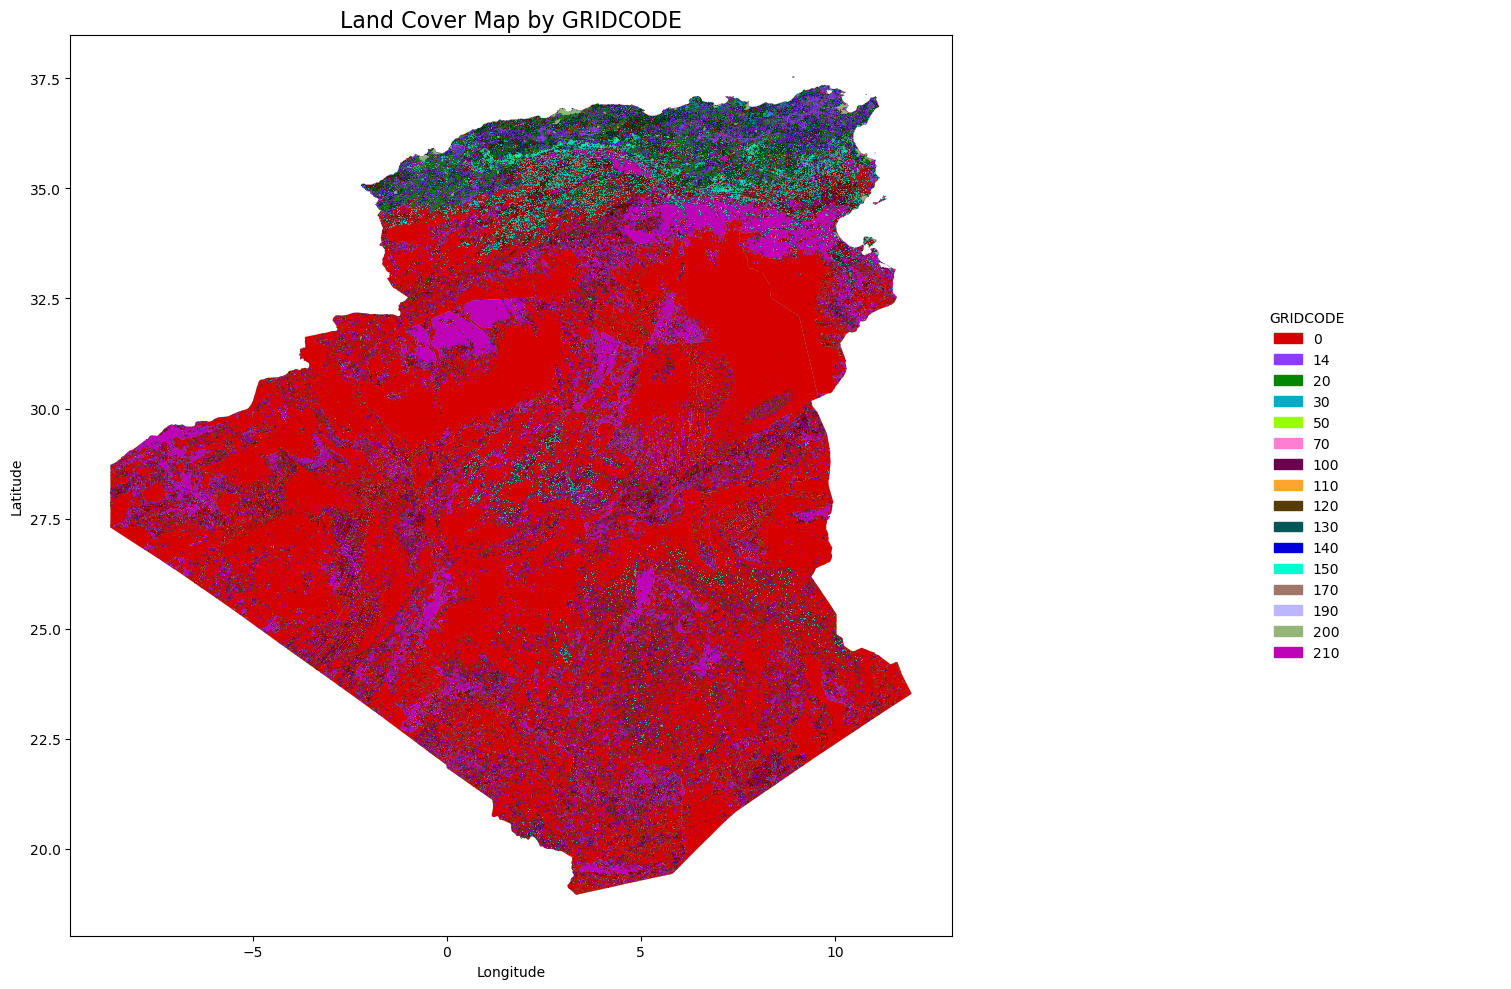

In [39]:
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs="EPSG:4326")
# Create color palette
palette = sns.color_palette(cc.glasbey, n_colors=merged_gdf['GRIDCODE'].nunique())
cmap = ListedColormap(palette)

# Create two subplots: map (left) + legend (right)
fig, (ax_map, ax_legend) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [4, 0.5]})

# --- Plot the map ---
merged_gdf.plot(
    column='GRIDCODE',
    cmap=cmap,
    linewidth=0.05,
    edgecolor='black',
    ax=ax_map,
    legend=False
)

ax_map.set_title("Land Cover Map by GRIDCODE", fontsize=16)
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")

# --- Create a separate legend on the right ---
# Get unique GRIDCODE values
unique_codes = merged_gdf['GRIDCODE'].unique()
unique_codes.sort()

# Create legend handles
from matplotlib.patches import Patch
handles = [Patch(color=cmap(i / len(unique_codes)), label=str(code)) for i, code in enumerate(unique_codes)]

ax_legend.legend(
    handles=handles,
    title="GRIDCODE",
    loc="center left",
    frameon=False
)
ax_legend.axis('off')  # remove axes for the legend subplot

# --- Final layout ---
plt.tight_layout()
plt.savefig(os.path.join(Images_dir, "landcover_map_GRIDCODE_clean.png"), dpi=300, bbox_inches='tight')
plt.show()


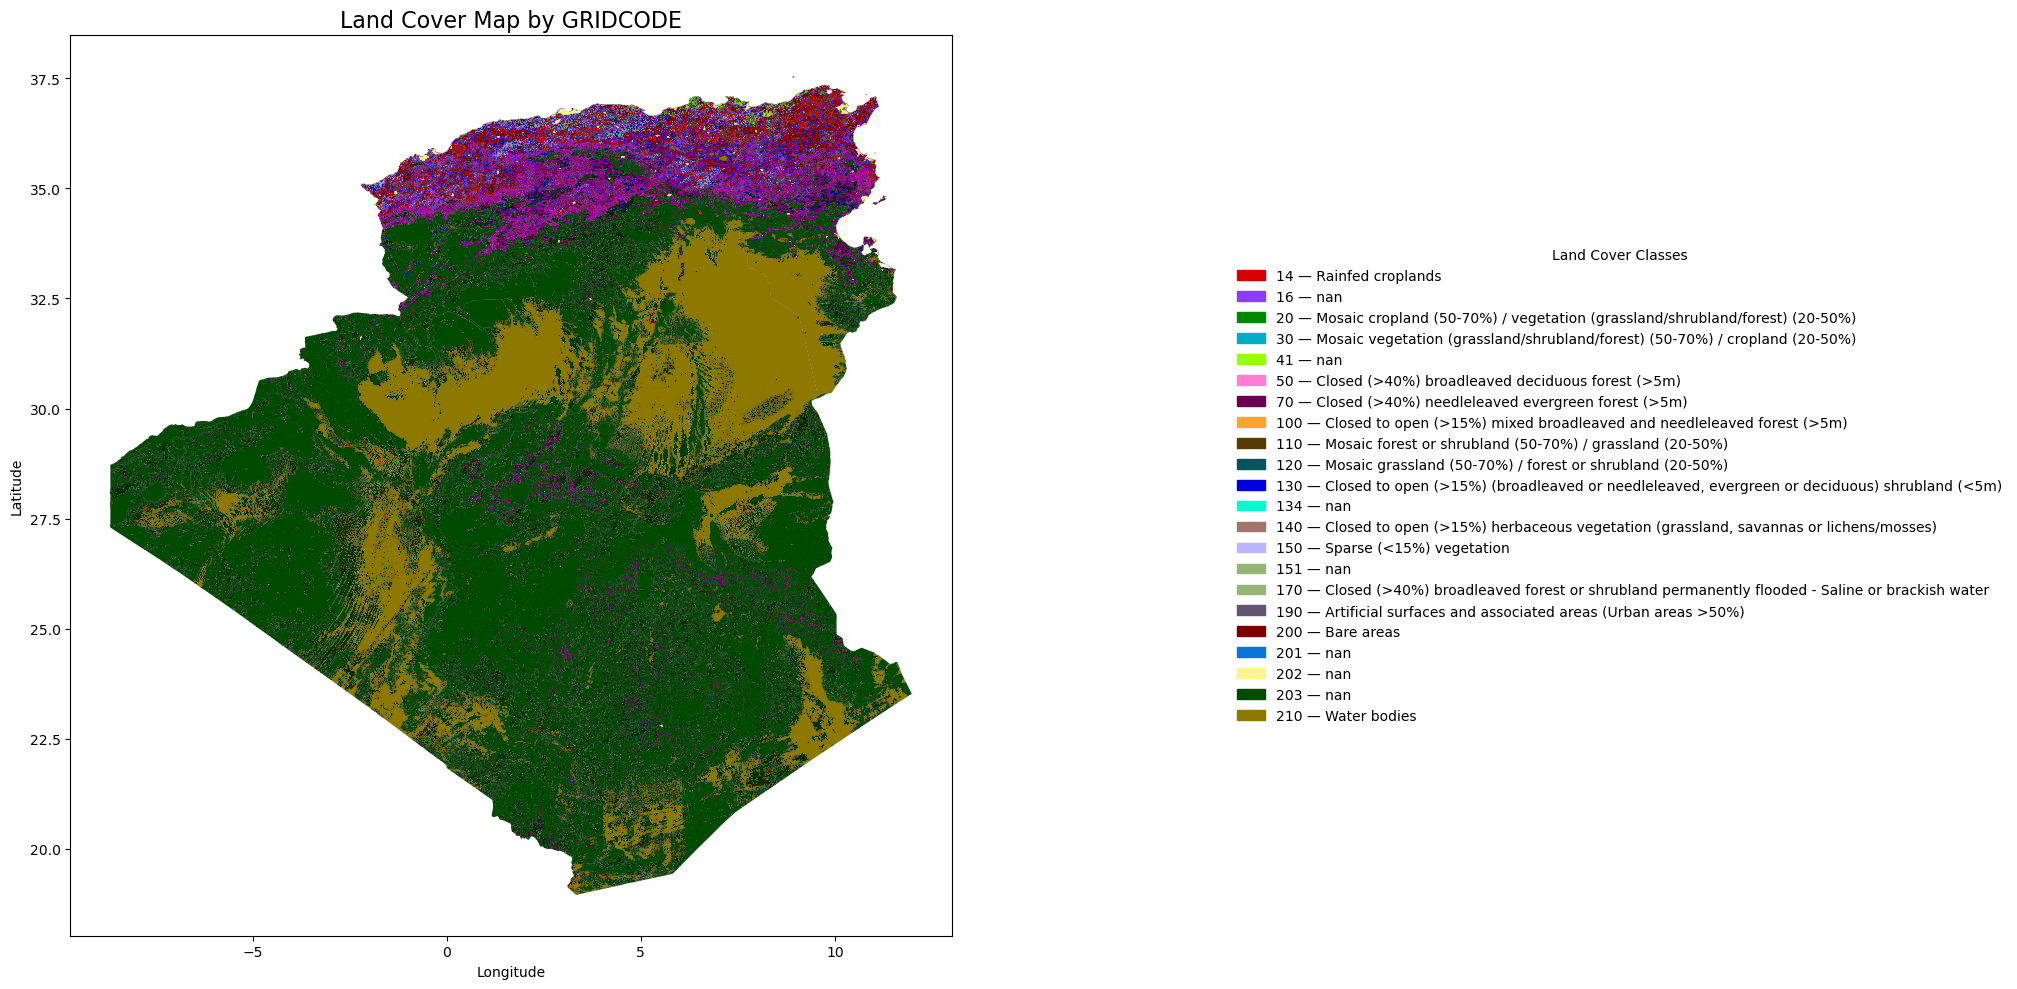

In [33]:
# Create color palette
palette = sns.color_palette(cc.glasbey, n_colors=merged_gdf['GRIDCODE'].nunique())
cmap = ListedColormap(palette)

# Create two subplots: map (left) + legend (right)
fig, (ax_map, ax_legend) = plt.subplots(1, 2, figsize=(28, 10), gridspec_kw={'width_ratios': [4, 0.7]})

# --- Plot the map ---
merged_gdf.plot(
    column='GRIDCODE',
    cmap=cmap,
    linewidth=0.05,
    edgecolor='black',
    ax=ax_map,
    legend=False
)
ax_map.set_title("Land Cover Map by GRIDCODE", fontsize=16)
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")

# --- Create legend using Label ---
unique_codes = merged_gdf[['GRIDCODE', 'Label']].drop_duplicates().sort_values('GRIDCODE')

# Create color handles with labels
handles = [
    Patch(color=cmap(i / len(unique_codes)), label=f"{row['GRIDCODE']} — {row['Label']}")
    for i, (_, row) in enumerate(unique_codes.iterrows())
]

ax_legend.legend(handles=handles, title="Land Cover Classes", loc="center left", frameon=False, fontsize=10)
ax_legend.axis('off')

# --- Final layout ---
plt.tight_layout()
plt.savefig(os.path.join(Images_dir, "landcover_map_GRIDCODE_labelled.png"), dpi=300, bbox_inches='tight')
plt.show()


## Bivariate Analysis

### LCCCode vs AREA

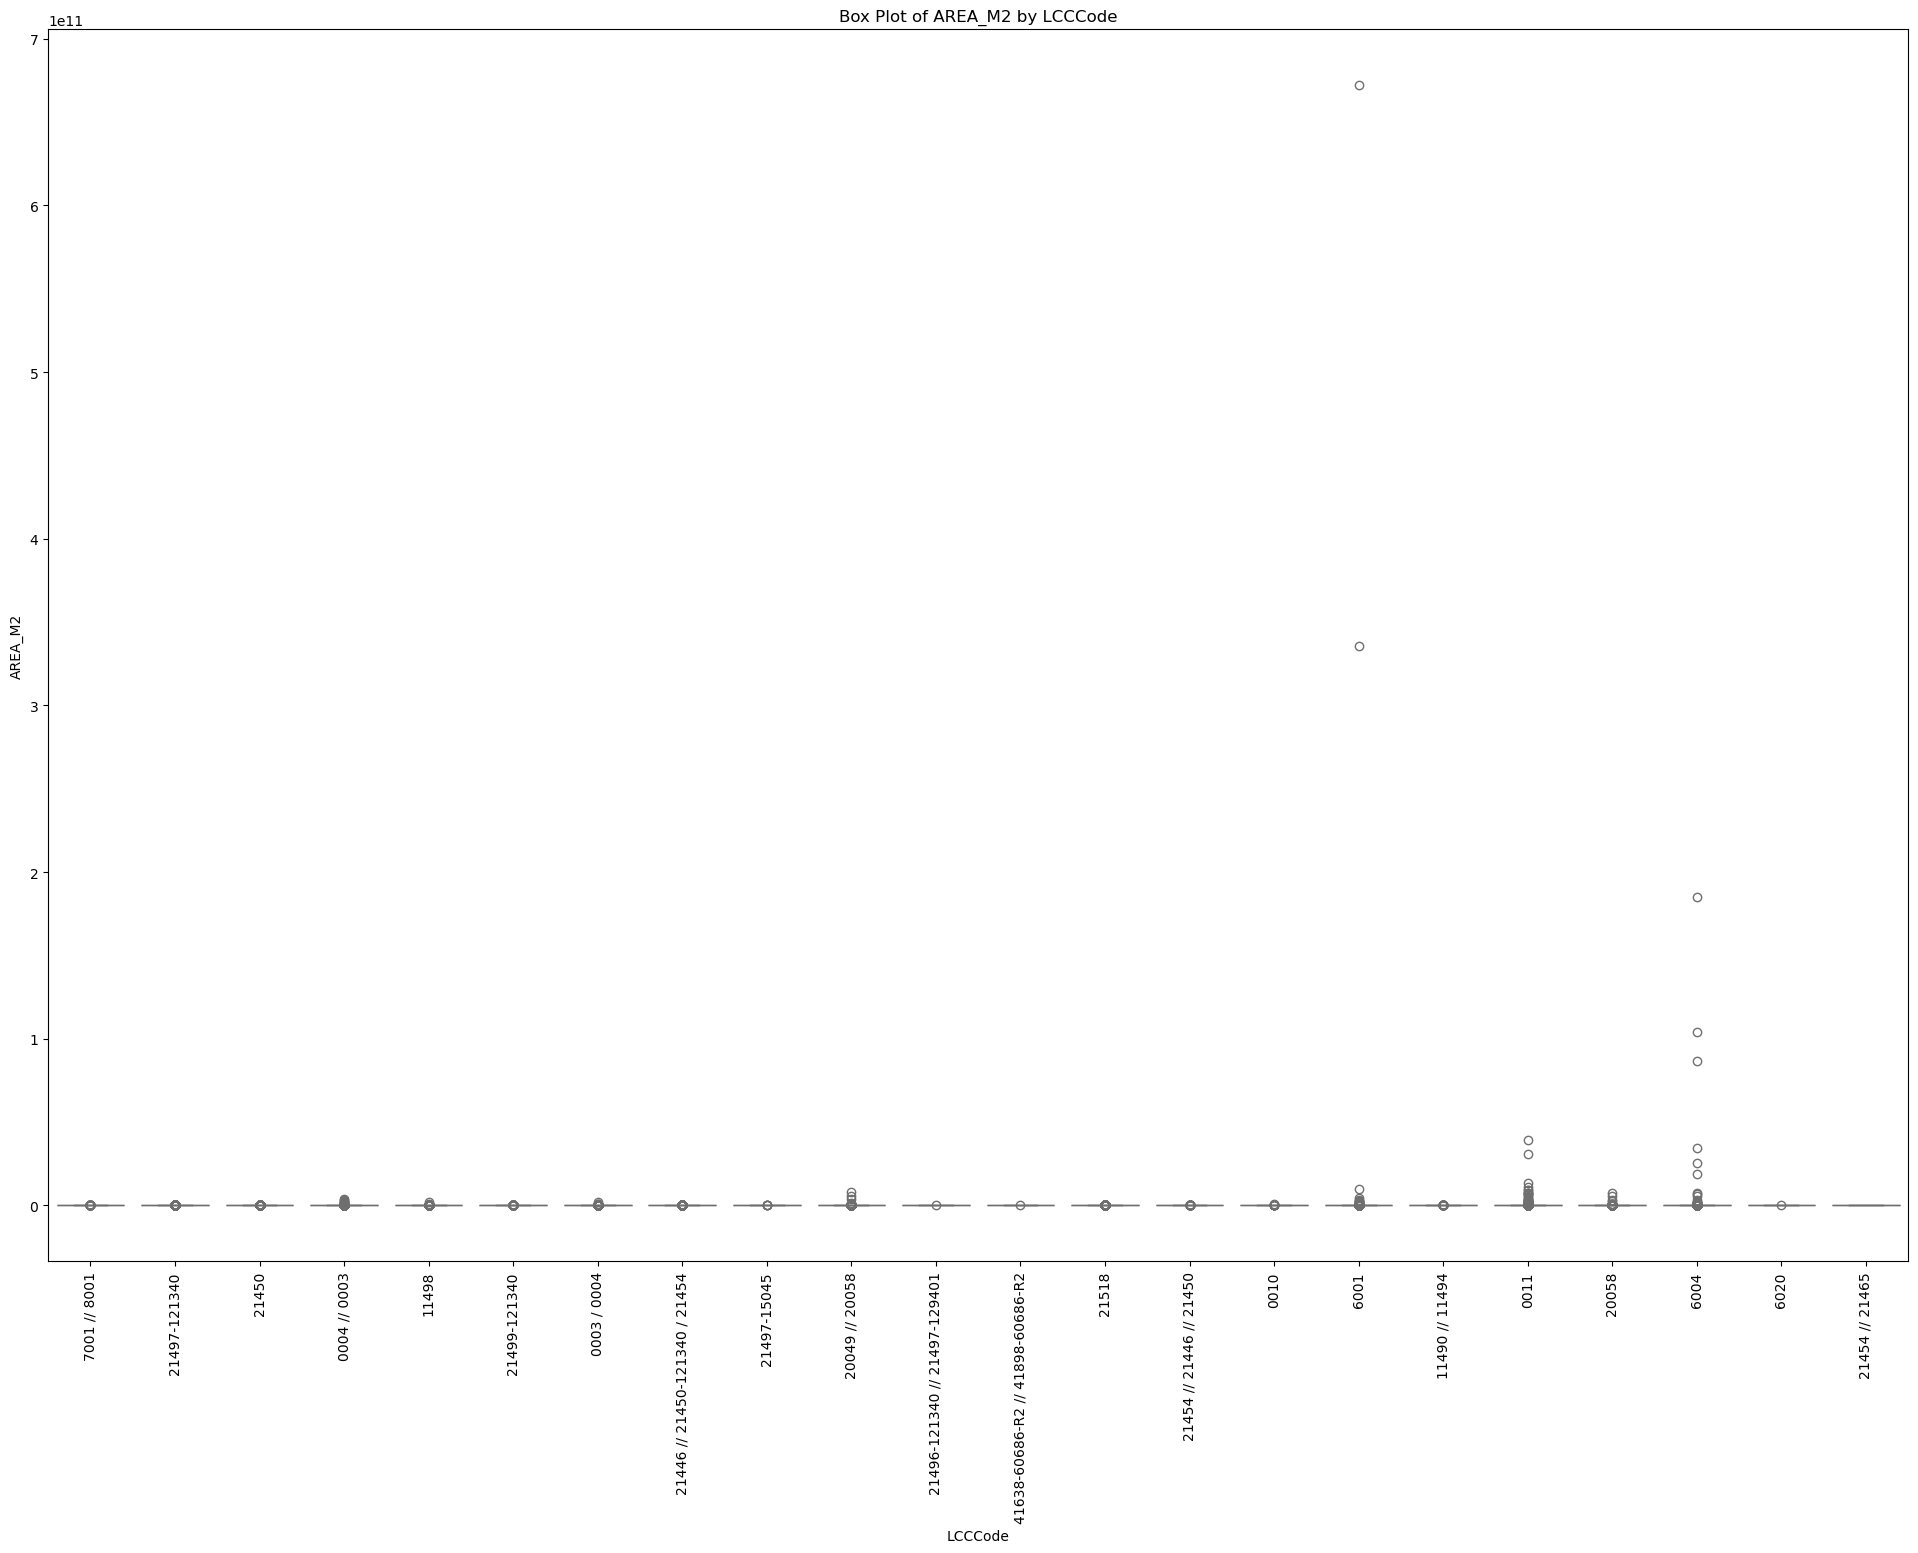

In [68]:
# box plot AREA_M2 by LCCCode
plt.figure(figsize=(24, 16))
sns.boxplot(data=landcover_df, x='LCCCode', y='AREA_M2', palette="pastel", hue='LCCCode', legend=False)
# rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.title("Box Plot of AREA_M2 by LCCCode")
plt.savefig(os.path.join(Images_dir, "landcover_boxplot_AREA_M2_by_LCCCode.png"), dpi=300, bbox_inches='tight')
plt.show()

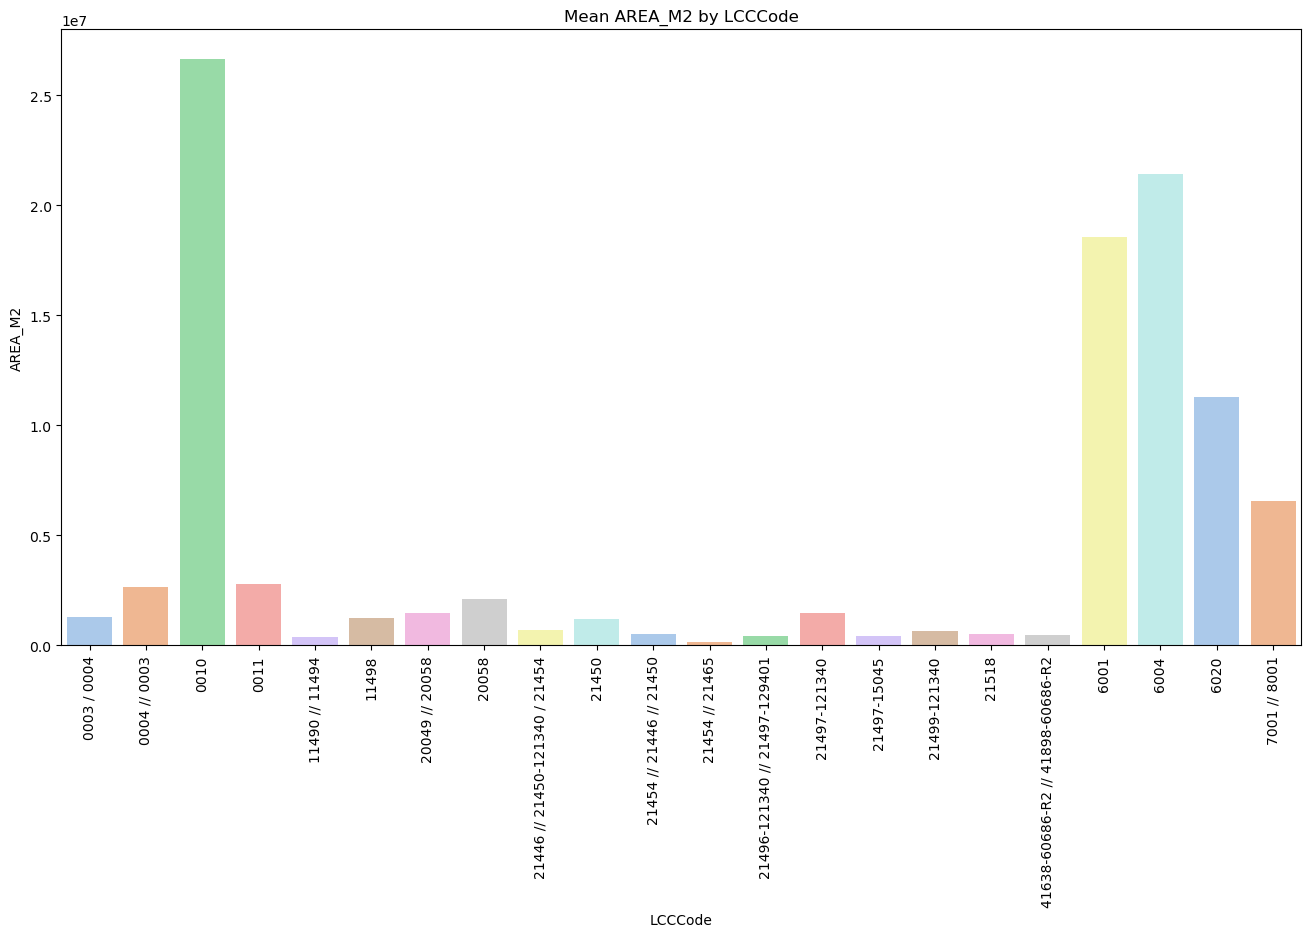

In [71]:
# mean AREA_M2 by LCCCode
mean_area_by_lcccode = landcover_df.groupby('LCCCode')['AREA_M2'].mean().reset_index()
plt.figure(figsize=(16, 8))
sns.barplot(data=mean_area_by_lcccode, x='LCCCode', y='AREA_M2', palette="pastel", hue='LCCCode', legend=False)
plt.xticks(rotation=90)
plt.title("Mean AREA_M2 by LCCCode")
plt.savefig(os.path.join(Images_dir, "landcover_mean_AREA_M2_by_LCCCode.png"), dpi=300, bbox_inches='tight')
plt.show()

In [76]:
# number of unique unique LCCCode per Area_M2
unique_lcccode_per_area = landcover_df.groupby('AREA_M2')['LCCCode'].nunique().reset_index()
unique_counts = unique_lcccode_per_area['LCCCode'].value_counts().reset_index()
print(unique_counts)


    LCCCode   count
0         1  211336
1         2   22367
2         3    9755
3         4    4163
4         5    1445
5         6     793
6         7     563
7         8     333
8         9     151
9        10      42
10       11       2


### LCCCode vs Gridcode

In [ ]:
# check LCCCode label where gridcode label==string 'nan' 
nan_gridcode_labels = merged_df[merged_df['GRIDCODE'] == 'nan']['LCCCode'].unique()
